In [17]:
import pandas as pd
from matplotlib import pyplot as plt
from lifelines.plotting import rmst_plot
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [18]:
raw_dat=pd.read_csv('match_stats.csv')

## event time sample
Create 3 dummy variables from the categorial status variable use these dummies to identify only those observations where an event has occurred or it is the current managerial spell.

In [19]:
dat = raw_dat.join(raw_dat["status"].str.get_dummies())
#dat.columns
events=dat.query("Poach==1 or Sack==1")
events['Exit']=1

/tmp/ipykernel_472205/132521366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['Exit']=1


## Univariate models and comparing *survival-ness* between different populations

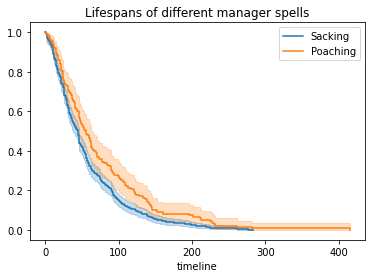

In [20]:
ax = plt.subplot(111)

T=events["games_in_charge"]
E=events["Exit"]
sack=(events["Sack"]==1)

kmf.fit(T[sack], event_observed=E[sack], label="Sacking")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~sack], event_observed=E[~sack], label="Poaching")
kmf.plot_survival_function(ax=ax)

plt.title("Lifespans of different manager spells");


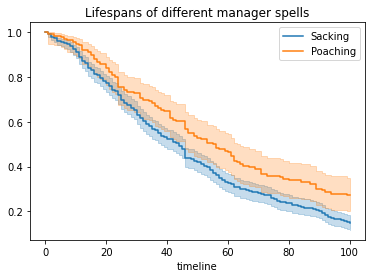

In [21]:
import numpy as np
ax = plt.subplot(111)
t = np.linspace(0, 100, 101)
kmf.fit(T[sack], event_observed=E[sack], timeline=t, label="Sacking")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~sack], event_observed=E[~sack], timeline=t ,label="Poaching")
kmf.plot_survival_function(ax=ax)

plt.title("Lifespans of different manager spells");


The y-axis represents the probability a manager is still around after t games in charge. The shaded areas is exponential Greenwood 95% confidence intervals.

>The complete lifespan of sacking spells and poaching spells appear to have the same survival function which seems counterintuitive give the common perception that managers are sacked much more often than they are poached.  When we consider the probabilites over a short time window this relationsihp persists.   

A pedantic log rank test will show is there is some naive statistical difference. Tihs test compares two event series generators.

In [22]:
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

results = logrank_test(T[sack], T[~sack], E[sack], E[~sack], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.48 <0.005      9.70

We can use restricted mean survival times (RMST) as a more accurate measure of the survival curves as their difference represents a measure of time lost.

In [23]:
time_limit = 100
kmf_poach=KaplanMeierFitter().fit(T[~sack], event_observed=E[~sack], label="Poaching")
kmf_sack=KaplanMeierFitter().fit(T[sack], event_observed=E[sack], label="Sacking")

<AxesSubplot:xlabel='timeline'>

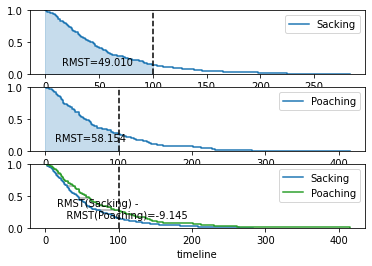

In [24]:
from matplotlib import pyplot as plt
from lifelines.plotting import rmst_plot

ax = plt.subplot(311)
rmst_plot(kmf_sack, t=time_limit, ax=ax)


ax = plt.subplot(312)
rmst_plot(kmf_poach, t=time_limit, ax=ax)


ax = plt.subplot(313)
rmst_plot(kmf_sack, model2=kmf_poach, t=time_limit, ax=ax)

The RMST suggests the average time lost by a team for managers who are sacked is 9 games. 

Time varying survival regression
=====================================

Cox's time varying proportional hazard model
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Often an individual will have a covariate change over time. An example of this is hospital patients who enter the study and, at some future time, may receive a heart transplant. We would like to know the effect of the transplant, but we must be careful if we condition on whether they received the transplant. Consider that if patients needed to wait at least 1 year before getting a transplant, then everyone who dies before that year is considered as a non-transplant patient, and hence this would overestimate the hazard of not receiving a transplant.

We can incorporate changes over time into our survival analysis by using a modification of the Cox model. The general mathematical description is:

$$
h(t | x) = \overbrace{b_0(t)}^{\text{baseline}}\underbrace{\exp \overbrace{\left(\sum_{i=1}^n \beta_i (x_i(t) - \overline{x_i}) \right)}^{\text{log-partial hazard}}}_ {\text{partial hazard}}
$$

Note the time-varying $x_i(t)$ to denote that covariates can change over time.

## Data preprocessing
create a start and a stop variable using lagged games in charge over the spell ID.  Spell ID is manager+club+finish date.

In [43]:
from datetime import datetime
dat["Finish"]=pd.to_datetime(dat["Finish"])
#dat=dat.set_index(['Club','Manager','Finish date'])
#dat["id"]=dat['id'].astype("category")
dat["Start"]=pd.to_datetime(dat['Start'])
dat["Date"]=pd.to_datetime(dat['Date'])
dat["event_s"]=np.where(dat["Sack"]==1,True,False)
dat["event_p"]=np.where(dat["Poach"]==1,True,False)
dat=dat.sort_values(['Club','Manager','Finish date','Date'])

In [48]:
df=dat[['Club','Manager','Finish date','Date','Relative_Strength','games_in_charge']]
df1=df.groupby(['Club','Manager','Finish date','Date'])['Relative_Strength'].sum() \
  .groupby(level=0).cumsum().reset_index()
df1=df1.join(dat[['games_in_charge','event_s','event_p']])
df1['start_games_in_charge'] = df1.groupby(['Club','Manager','Finish date'])['games_in_charge'].shift()
df1['start_games_in_charge']=df1['start_games_in_charge'].fillna(0)
df1['id']=df1['Club']+"-"+df1['Manager']+"-"+df1['Finish date']
df1['RS_ncum']=df1['Relative_Strength']/(3*df1['games_in_charge'])
df1[df1['games_in_charge']<df1['start_games_in_charge']][df1['games_in_charge']>3]
df1.describe()

/tmp/ipykernel_472205/3815785726.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1[df1['games_in_charge']<df1['start_games_in_charge']][df1['games_in_charge']>3]


,Relative_Strength,games_in_charge,start_games_in_charge,RS_ncum
count,46280.000000,46280.000000,46280.000000,46280.000000
mean,82.265609,60.262662,59.363137,1.590452
std,64.592479,59.193696,59.222255,4.556693
min,-76.478808,1.000000,0.000000,-13.523765
25%,29.122086,18.000000,17.000000,0.179283
50%,72.625438,42.000000,41.000000,0.443399
75%,121.505275,83.000000,82.000000,1.198955
max,330.784128,415.000000,415.000000,95.618855


Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -3051.75699, newton_decrement = 0.00000, seconds_since_start = 2.1Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 42814 periods, 700 subjects, 498 events>
         event col = 'event_s'
         penalizer = 0.001
number of subjects = 700
 number of periods = 42814
  number of events = 498
partial log-likelihood = -3051.76
  time fit was run = 2021-12-23 09:08:27 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
RS_ncum     0.19       1.21       0.04             0.11             0.27                 1.11                 1.31

             z      p   -log2(p)
covariate                       
RS_ncum   4.51 <0.005      17.20
---
Partial AIC = 6105.51
log-likelihood ratio test = 18.40 on 1 df
-log2(p) of ll-ratio test = 15.77

<AxesSubplot:xlabel='log(HR) (95% CI)'>

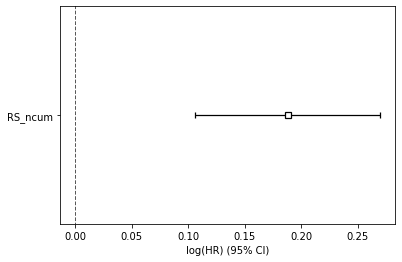

In [45]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.001)
df2=df1[['id','event_s','start_games_in_charge','games_in_charge','RS_ncum']][df1['games_in_charge']>5]
ctv.fit(df2, id_col="id", event_col="event_s", start_col="start_games_in_charge", stop_col="games_in_charge", show_progress=True)
ctv.print_summary()
#ctv.plot()

In [47]:
ctv = CoxTimeVaryingFitter(penalizer=0.001)
df2=df1[['id','event_p','start_games_in_charge','games_in_charge','RS_ncum']][df1['games_in_charge']>5]
ctv.fit(df2, id_col="id", event_col="event_p", start_col="start_games_in_charge", stop_col="games_in_charge", show_progress=True)
ctv.print_summary()

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -773.87398, newton_decrement = 0.00000, seconds_since_start = 1.4Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 42814 periods, 700 subjects, 133 events>
         event col = 'event_p'
         penalizer = 0.001
number of subjects = 700
 number of periods = 42814
  number of events = 133
partial log-likelihood = -773.87
  time fit was run = 2021-12-23 09:09:49 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
RS_ncum     0.15       1.16       0.08            -0.01             0.30                 0.99                 1.35

             z    p   -log2(p)
covariate                     
RS_ncum   1.89 0.06       4.08
---
Partial AIC = 1549.75
log-likelihood ratio test = 3.38 on 1 df
-log2(p) of ll-ratio test = 3.92